In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import itertools as it
import scipy.stats.qmc as ssq
from scipy.stats import chisquare, truncnorm
from seaborn import displot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space.space import Real, Integer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, KBinsDiscretizer
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer

np.set_printoptions(threshold=100_000)
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
# X = X[['gamma_g', 't_peak', 'gamma_d', 'sd_antarctic',
#        'rho_greenland', 'rho_gmsl', 'temperature_0', 'ocean_heat_0', 'Q10',
#        'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol',
#        'climate_sensitivity', 'thermal_alpha', 'greenland_a', 'greenland_b',
#        'greenland_alpha', 'greenland_beta', 'anto_alpha', 'antarctic_mu',
#        'antarctic_precip0', 'antarctic_runoff_height0', 'antarctic_lambda',
#        'antarctic_temp_threshold', 'lw_random_sample']].copy()
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
X.t_peak = X.t_peak.astype('category')
obj = X.join(Y, how='left')
obj.sort_values(by='t_peak',ascending=True, inplace=True)
# Rescaling the dataset
# min_max = MinMaxScaler()
# min_max.fit(obj.iloc[:,:-1],obj.iloc[:,-1])

# obj_scaled = min_max.transform(obj.iloc[:,:-1])
# obj_y = obj.iloc[:,-1].copy()


In [2]:
nun = len(X.t_peak.unique())
discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
Y_binned = discret.fit_transform(Y.to_numpy().reshape(-1,1)).ravel()
smote = SMOTENC(categorical_features=['t_peak'],sampling_strategy='auto', random_state=0)
X_res , y_res = smote.fit_resample(X, Y_binned)

In [3]:
Y1 = pd.Series(discret.inverse_transform(y_res.reshape(-1,1)).ravel(), name='output')
obj1 = X_res.join(Y1, how='left')

In [4]:
obj1.sort_values(by='t_peak', inplace=True)

In [5]:
obj1.head(5)

,gamma_g,t_peak,gamma_d,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,rho_temperature,...,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
16276,0.007032,2030.0,0.144645,0.079195,0.956147,0.000198,0.000258,0.000501,0.001693,0.556753,...,0.051193,1.091393,1088.769941,87.814430,786.867486,0.000717,0.005617,-16.166066,0.000085,0.315824
60434,0.013547,2030.0,0.086745,0.074217,0.529761,0.000066,0.000231,0.000351,0.002021,0.574180,...,0.048803,1.404655,1814.605922,132.399778,773.312080,0.000739,0.013687,-15.455946,0.000295,0.438265
51254,0.010473,2030.0,0.106480,0.077831,3.236026,0.000421,0.000222,0.000569,0.000581,0.461446,...,0.077969,0.921405,1059.688107,114.661609,780.601762,0.000677,0.012714,-16.246661,0.000038,0.409804
85424,0.002159,2030.0,0.161543,0.077272,0.233191,0.000554,0.000243,0.000372,0.001776,0.497281,...,0.036758,1.377534,1868.838490,138.796071,768.440622,0.000692,0.011776,-15.546623,0.000052,0.315824
83384,0.002947,2030.0,0.104271,0.077386,3.041196,0.000252,0.000226,0.000443,0.002437,0.514229,...,0.070303,1.049404,1396.007982,112.968773,803.296236,0.000716,0.007405,-14.962388,0.000283,0.473420


In [6]:
val = train_test_split(obj1.iloc[:,:-1],obj1.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
# val = TimeSeriesSplit(n_splits=4, max_train_size=60_066)
#Darnell MSE8 n_estimators=199, max_depth=26, max_features=30, min_samples_leaf=2,n_jobs=10,
# Darnell MSE10:max_depth=36, max_features=33, n_estimators=300,
# max_depth=38, max_features=17,n_estimators=300
#==================================================================================================
RF = RandomForestRegressor(n_estimators=295, max_features=47, max_depth=55, n_jobs=20,random_state=0)

In [7]:
RF.fit(val[0], val[2])

RandomForestRegressor(max_depth=55, max_features=47, n_estimators=295,
                      n_jobs=20, random_state=0)

In [8]:
print(f'Train MSE={np.mean(np.square(val[2].to_numpy()-RF.predict(val[0].to_numpy())))}')
print(f'Test MSE={np.mean(np.square(val[3].to_numpy()-RF.predict(val[1].to_numpy())))}')
# print(f'Importances:\n{RF.feature_importances_}')

c:\Users\dwigh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Train MSE=0.0022812833033538336
Test MSE=0.1438879748862947


c:\Users\dwigh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [9]:
parameter_space = dict()
parameter_space['n_estimators'] = Integer(30,300)
# parameter_space['min_samples_split'] = Integer(2,5, prior='uniform')
# parameter_space['min_samples_leaf'] = Integer(1,5)
parameter_space['max_features'] = Integer(10,53)
parameter_space['max_depth'] = Integer(10,80)
# parameter_space['ccp_alpha'] = Real(1e-4, 5e-4)

In [14]:
bae = BayesSearchCV(estimator=RF,search_spaces=parameter_space,verbose=2, n_iter=100, scoring='neg_mean_squared_error', n_points=6, cv=val, n_jobs=24, random_state=0)
bae.fit(obj1.iloc[:,:-1], obj1.iloc[:,-1])
res = pd.DataFrame(bae.cv_results_)
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_12.xlsx")
res.to_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_12.csv")
print(f'Best Parameters:{bae.best_params_} with MSE: {bae.best_score_}')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Parameters:OrderedDict([('max_depth

In [10]:
rng = np.random.default_rng(seed=0)
def bootstrapp(y_true,y_pred,n_boots):
    rows = len(y_true)
    error = (y_true - y_pred).to_numpy()
    S_CI = np.zeros((n_boots,))
    for i in range(n_boots):
        indx = rng.choice(rows, size=rows, replace=True)
        S_CI[i] = np.mean(np.square(error[indx]))
    return S_CI

In [11]:
def pvi1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    # rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    rolled_data = np.roll(data.copy(),rows//2, axis=0)
    # for cat,col in npv_columns.items():
    for col in npv_columns:
        d = rolled_data.copy()
        d[:, col] = data[:,col]
        y_pred = f(d)
        u[col] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
    #     S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
    #     p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
    #     CI[col] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'
    # SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u

In [20]:
def mod_pvi1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for cat, col in npv_columns.items():
        d = rolled_data.copy()
        d[col] = data[col].to_numpy()
        y_pred = f(d)
        u[cat] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[cat] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u,CI

In [13]:
def pvi_t(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = np.zeros((columns,))
    V_y = np.var(y_true, ddof=1)
    CI = dict()
    for col in npv_columns:
        d = data.copy()
        d[:, col] = np.roll(data[:, col],rows//2, axis=0)
        y_pred = f(d)
        u[col] = np.mean(np.square(y_true - y_pred))/(2*V_y)
    #     S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
    #     p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
    #     CI[col] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'
    # S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u

In [14]:
def mod_pvi_t(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = dict()
    V_y = np.var(y_true,ddof=1 )
    CI = dict()
    for cat,col in npv_columns.items():
        d = data.copy()
        d[col] = np.roll(data[col],rows//2, axis=0)
        y_pred = f(d)
        u[cat] = np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[cat] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u, CI

In [15]:
def pvi2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = np.zeros((columns, columns))
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    # rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    rolled_data = np.roll(data.copy(),rows//2, axis=0)
    for col1,col2 in it.combinations(npv_columns, r=2):
        d = rolled_data.copy()
        d[:,[col1, col2]] = data[:,[col1,col2]]
        y_pred = f(d)
        S_cat1 = S_I[col1]
        S_cat2 = S_I[col2]
        print(f'First-Order:\t{S_cat1, S_cat2}')
        # print(f'First Part:\t{np.mean(np.square(y_true - f(d)))/(2*V_y)}')
        # print(f'Second Part:\t{S_cat1}')
        # print(f'Third Part:\t{S_cat2}')
        S[col1, col2] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        print(f'Second-Order:\t{S[col1,col2]}')

    #     S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2
    #     p0,p1= np.quantile(S_CI, [alpha,1-alpha])
    #     CI[(col1, col2)] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S

In [21]:
def mod_pvi2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = dict()
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for (cat1,col1),(cat2, col2) in it.combinations(npv_columns.items(), r=2):
        col = col1+col2
        d = rolled_data.copy()
        d[col] = data[col].to_numpy()
        y_pred = f(d)
        S_cat1 = S_I[cat1]
        S_cat2 = S_I[cat2]
        S[(cat1, cat2)] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2 # Bootstrap Process
        p0,p1= np.quantile(S_CI, [alpha,1-alpha])
        CI[(cat1, cat2)] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S, CI

In [22]:
Variables = ['sd_temp', 'sd_ocean_heat', 'sd_glaciers', 'sd_greenland','sd_antarctic',
              'sd_gmsl', 'rho_temperature','rho_ocean_heat', 
              'rho_glaciers', 'rho_greenland', 'rho_antarctic','rho_gmsl']
Climate = ['CO2_0', 'N2O_0', 'temperature_0','ocean_heat_0','Q10', 'CO2_fertilization',
           'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol','climate_sensitivity']
Glaciers = ['glaciers_v0','glaciers_s0','glaciers_beta0', 'glaciers_n']
Thermals = ['thermal_s0', 'thermal_alpha']

Greenland = ['greenland_a', 'greenland_b','greenland_alpha', 'greenland_beta']
Antarctic = [ 'antarctic_gamma', 'antarctic_alpha','antarctic_mu', 'antarctic_nu',
              'antarctic_precip0', 'antarctic_kappa','antarctic_flow0', 'antarctic_runoff_height0',
                'antarctic_c','antarctic_bed_height0', 'antarctic_slope', 'antarctic_lambda','antarctic_temp_threshold',
                'antarctic_s0','anto_alpha', 'anto_beta']

In [23]:
# column_set = val[0].columns
# print(column_set)
npv_column_set = dict()
npv_column_set['Variables'] = Variables
npv_column_set['Climate'] = Climate
# npv_column_set['Glaciers'] = Glaciers
npv_column_set['Thermals'] = Thermals
npv_column_set['Greenland'] = Greenland
npv_column_set['Antarctic'] = Antarctic
npv_column_set['Emissions'] = ['gamma_g', 't_peak', 'gamma_d', 'lw_random_sample']

In [24]:
PI, CI= mod_pvi1(val[0], val[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
print(f'First-Order PVi:\n{pd.DataFrame(PI.values(), index=PI.keys())}\n')
print(f'Confidence Intervals:{CI}')

First-Order PVi:
                  0
Variables -0.078121
Climate    0.113479
Thermals  -0.094761
Greenland -0.082619
Antarctic  0.078378
Emissions  0.547402

Confidence Intervals:Confidence Interval Difference       5th      95th  Quantile Difference
Interactions                                                           
Variables                      -0.086396 -0.070068             0.016329
Climate                         0.107413  0.119846             0.012433
Thermals                       -0.102708 -0.087489             0.015219
Greenland                      -0.090165 -0.074869             0.015296
Antarctic                       0.071396  0.086057             0.014660
Emissions                       0.542645  0.551842             0.009197


In [25]:
def donut_chart(values: np.ndarray, values1: np.ndarray, labels: list,labels1: list, props: dict, kw: dict):
    fig, ax= plt.subplots(1,2,dpi=500, figsize=(20,25))
    wedges0, text0 = ax[0].pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges0):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[0].annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[0].set_title('SNEASY-BRICK: First & Second-Order PVi')
    ax[0].legend(labels=labels,loc='center', title='PVi Indices:' )

    wedges1, text1 = ax[1].pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges1):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[1].annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[1].set_title('SNEASY-BRICK: Total-Order PVi')
    ax[1].legend(labels=labels1,loc='center', title='PVi Indices:' )
    plt.show()

In [26]:
PT= mod_pvi_t(val[0], val[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
PT

({'Variables': 0.011941326114549847,
  'Climate': 0.2590960596374863,
  'Thermals': 0.006626805207867255,
  'Greenland': 0.012854080072026392,
  'Antarctic': 0.249766255623056,
  'Emissions': 0.7499950405789741},
 Confidence Interval Difference       5th      95th  Quantile Difference
 Interactions                                                           
 Variables                       0.011712  0.012156             0.000443
 Climate                         0.255954  0.262259             0.006306
 Thermals                        0.006495  0.006762             0.000267
 Greenland                       0.012659  0.013051             0.000392
 Antarctic                       0.246971  0.252368             0.005397
 Emissions                       0.744531  0.755535             0.011004)

In [27]:
PIK,CIK= mod_pvi2(val[0], val[2], RF.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=npv_column_set)
PIK = pd.DataFrame(PIK.values(), index=PIK.keys(), columns=[r'$P_{ik}$'])

In [28]:
PIK

$P_{ik}$
Variables Climate    0.081998
          Thermals   0.095742
          Greenland  0.092593
          Antarctic  0.080196
          Emissions  0.083429
Climate   Thermals   0.095392
          Greenland  0.090147
          Antarctic  0.050626
          Emissions  0.077154
Thermals  Greenland  0.095894
          Antarctic  0.093528
          Emissions  0.093817
Greenland Antarctic  0.083977
          Emissions  0.087878
Antarctic Emissions  0.109233

In [32]:
pd.DataFrame(PI.values(), index=PI.keys()).sum(axis=0)

0    0.483759
dtype: float64

In [42]:
props = dict()
kw = dict()
props['textprops'] = {'fontsize':14}
props['startangle'] = -270
props['wedgeprops'] = {'width': 0.2}
kw['arrowprops'] = dict(arrowstyle='-')
kw['zorder'] = 0
kw['va'] = 'center'
colors = ['#CF0057','#FF0054','#F72585', '#B5179E', '#7209B7', '#560BAD','#8F3DC1','#A96FD1',
          '#C3A3E0', '#8F6FD1', '#480CA8', '#3A0CA3','#141440','#A3A3E0', '#6F6FD1', '#3D3DC1',
          '#4361EE','#4CC9F0','#1DE48D','#6B007B','#B51CE4','#E044A7', '#744EC2']
props['colors'] = colors

In [33]:
PI = pd.DataFrame(PI.values(), index=PI.keys(), columns=[r'$P_{i}$'])

In [34]:
inner = PI.to_dict()[r'$P_{i}$']
inner = {key: value for key, value in inner.items() if value>0}

In [35]:
left_inner = PIK.to_dict()[r'$P_{ik}$']
left_inner = {','.join(key): value for key,value in left_inner.items()}

In [36]:
inner

{'Climate': 0.11347918411650182,
 'Antarctic': 0.07837807002362862,
 'Emissions': 0.54740162293715}

In [37]:
merged_indices = inner|left_inner
labels = list(merged_indices.keys())
values = list(merged_indices.values())

In [38]:
PT, CT = PT

In [39]:
labels1 = list(PT.keys())
values1 = list(PT.values())

In [40]:
merged_indices

{'Climate': 0.11347918411650182,
 'Antarctic': 0.07837807002362862,
 'Emissions': 0.54740162293715,
 'Variables,Climate': 0.08199770201339085,
 'Variables,Thermals': 0.09574245323717201,
 'Variables,Greenland': 0.0925925163071879,
 'Variables,Antarctic': 0.08019627061735657,
 'Variables,Emissions': 0.08342946631990544,
 'Climate,Thermals': 0.09539167577735064,
 'Climate,Greenland': 0.09014717829256258,
 'Climate,Antarctic': 0.05062576913811723,
 'Climate,Emissions': 0.07715408231976528,
 'Thermals,Greenland': 0.09589437536119183,
 'Thermals,Antarctic': 0.09352849966850985,
 'Thermals,Emissions': 0.0938168194248975,
 'Greenland,Antarctic': 0.08397700655492779,
 'Greenland,Emissions': 0.08787759472617374,
 'Antarctic,Emissions': 0.10923263861138921}

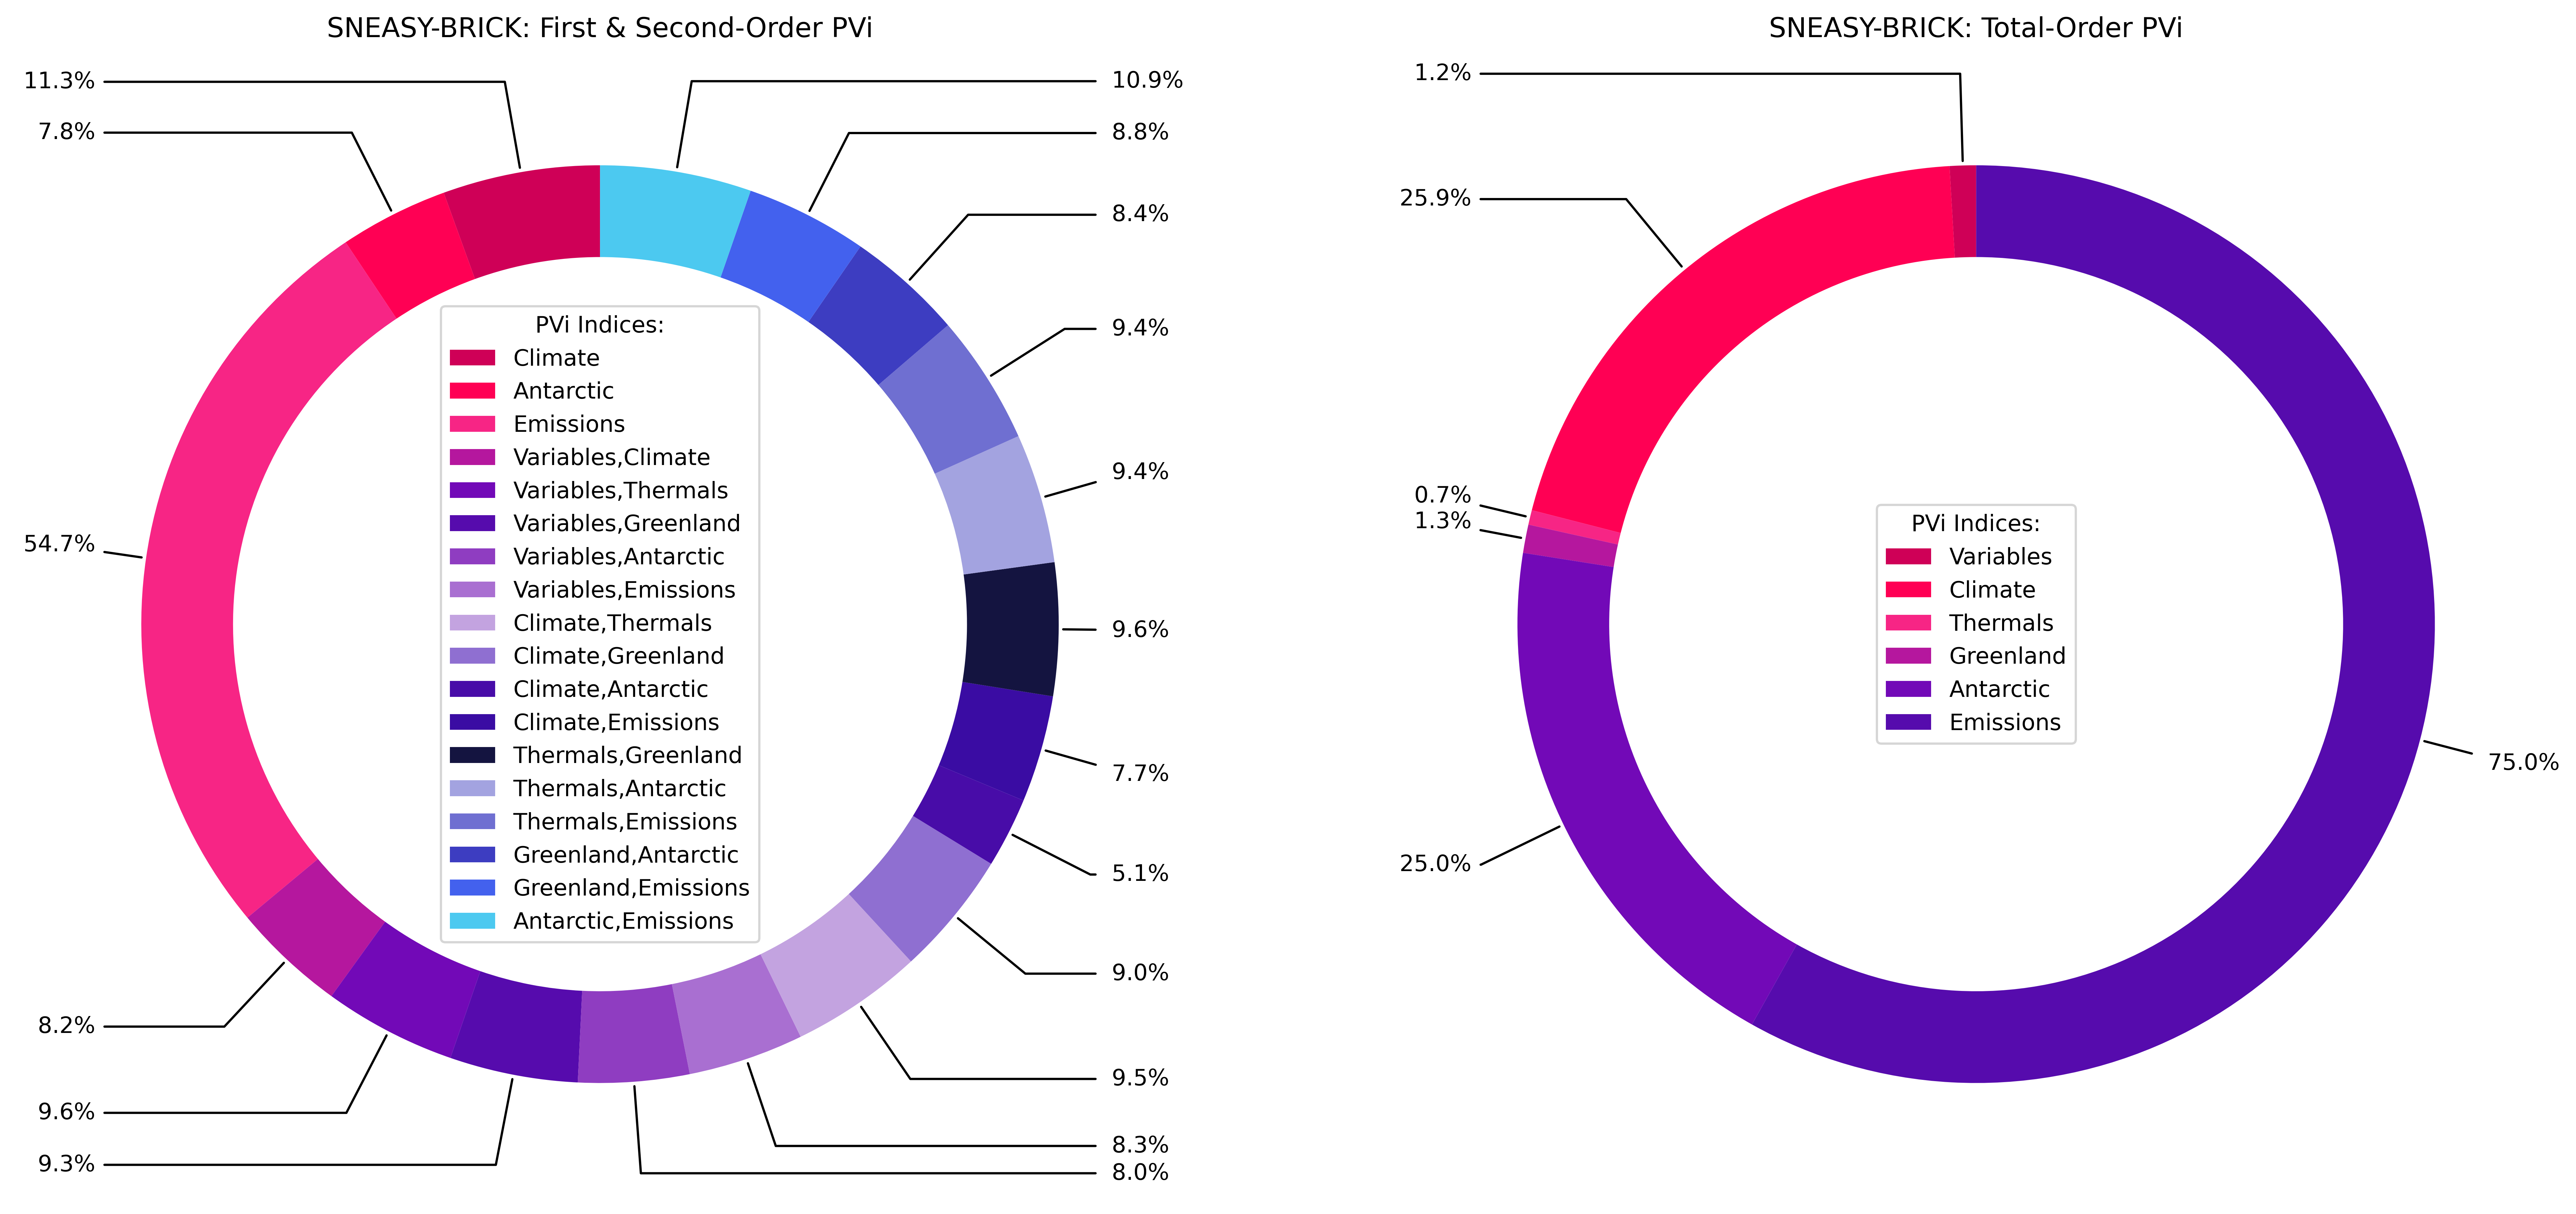

In [43]:
donut_chart(values, values1, labels, labels1, props, kw)

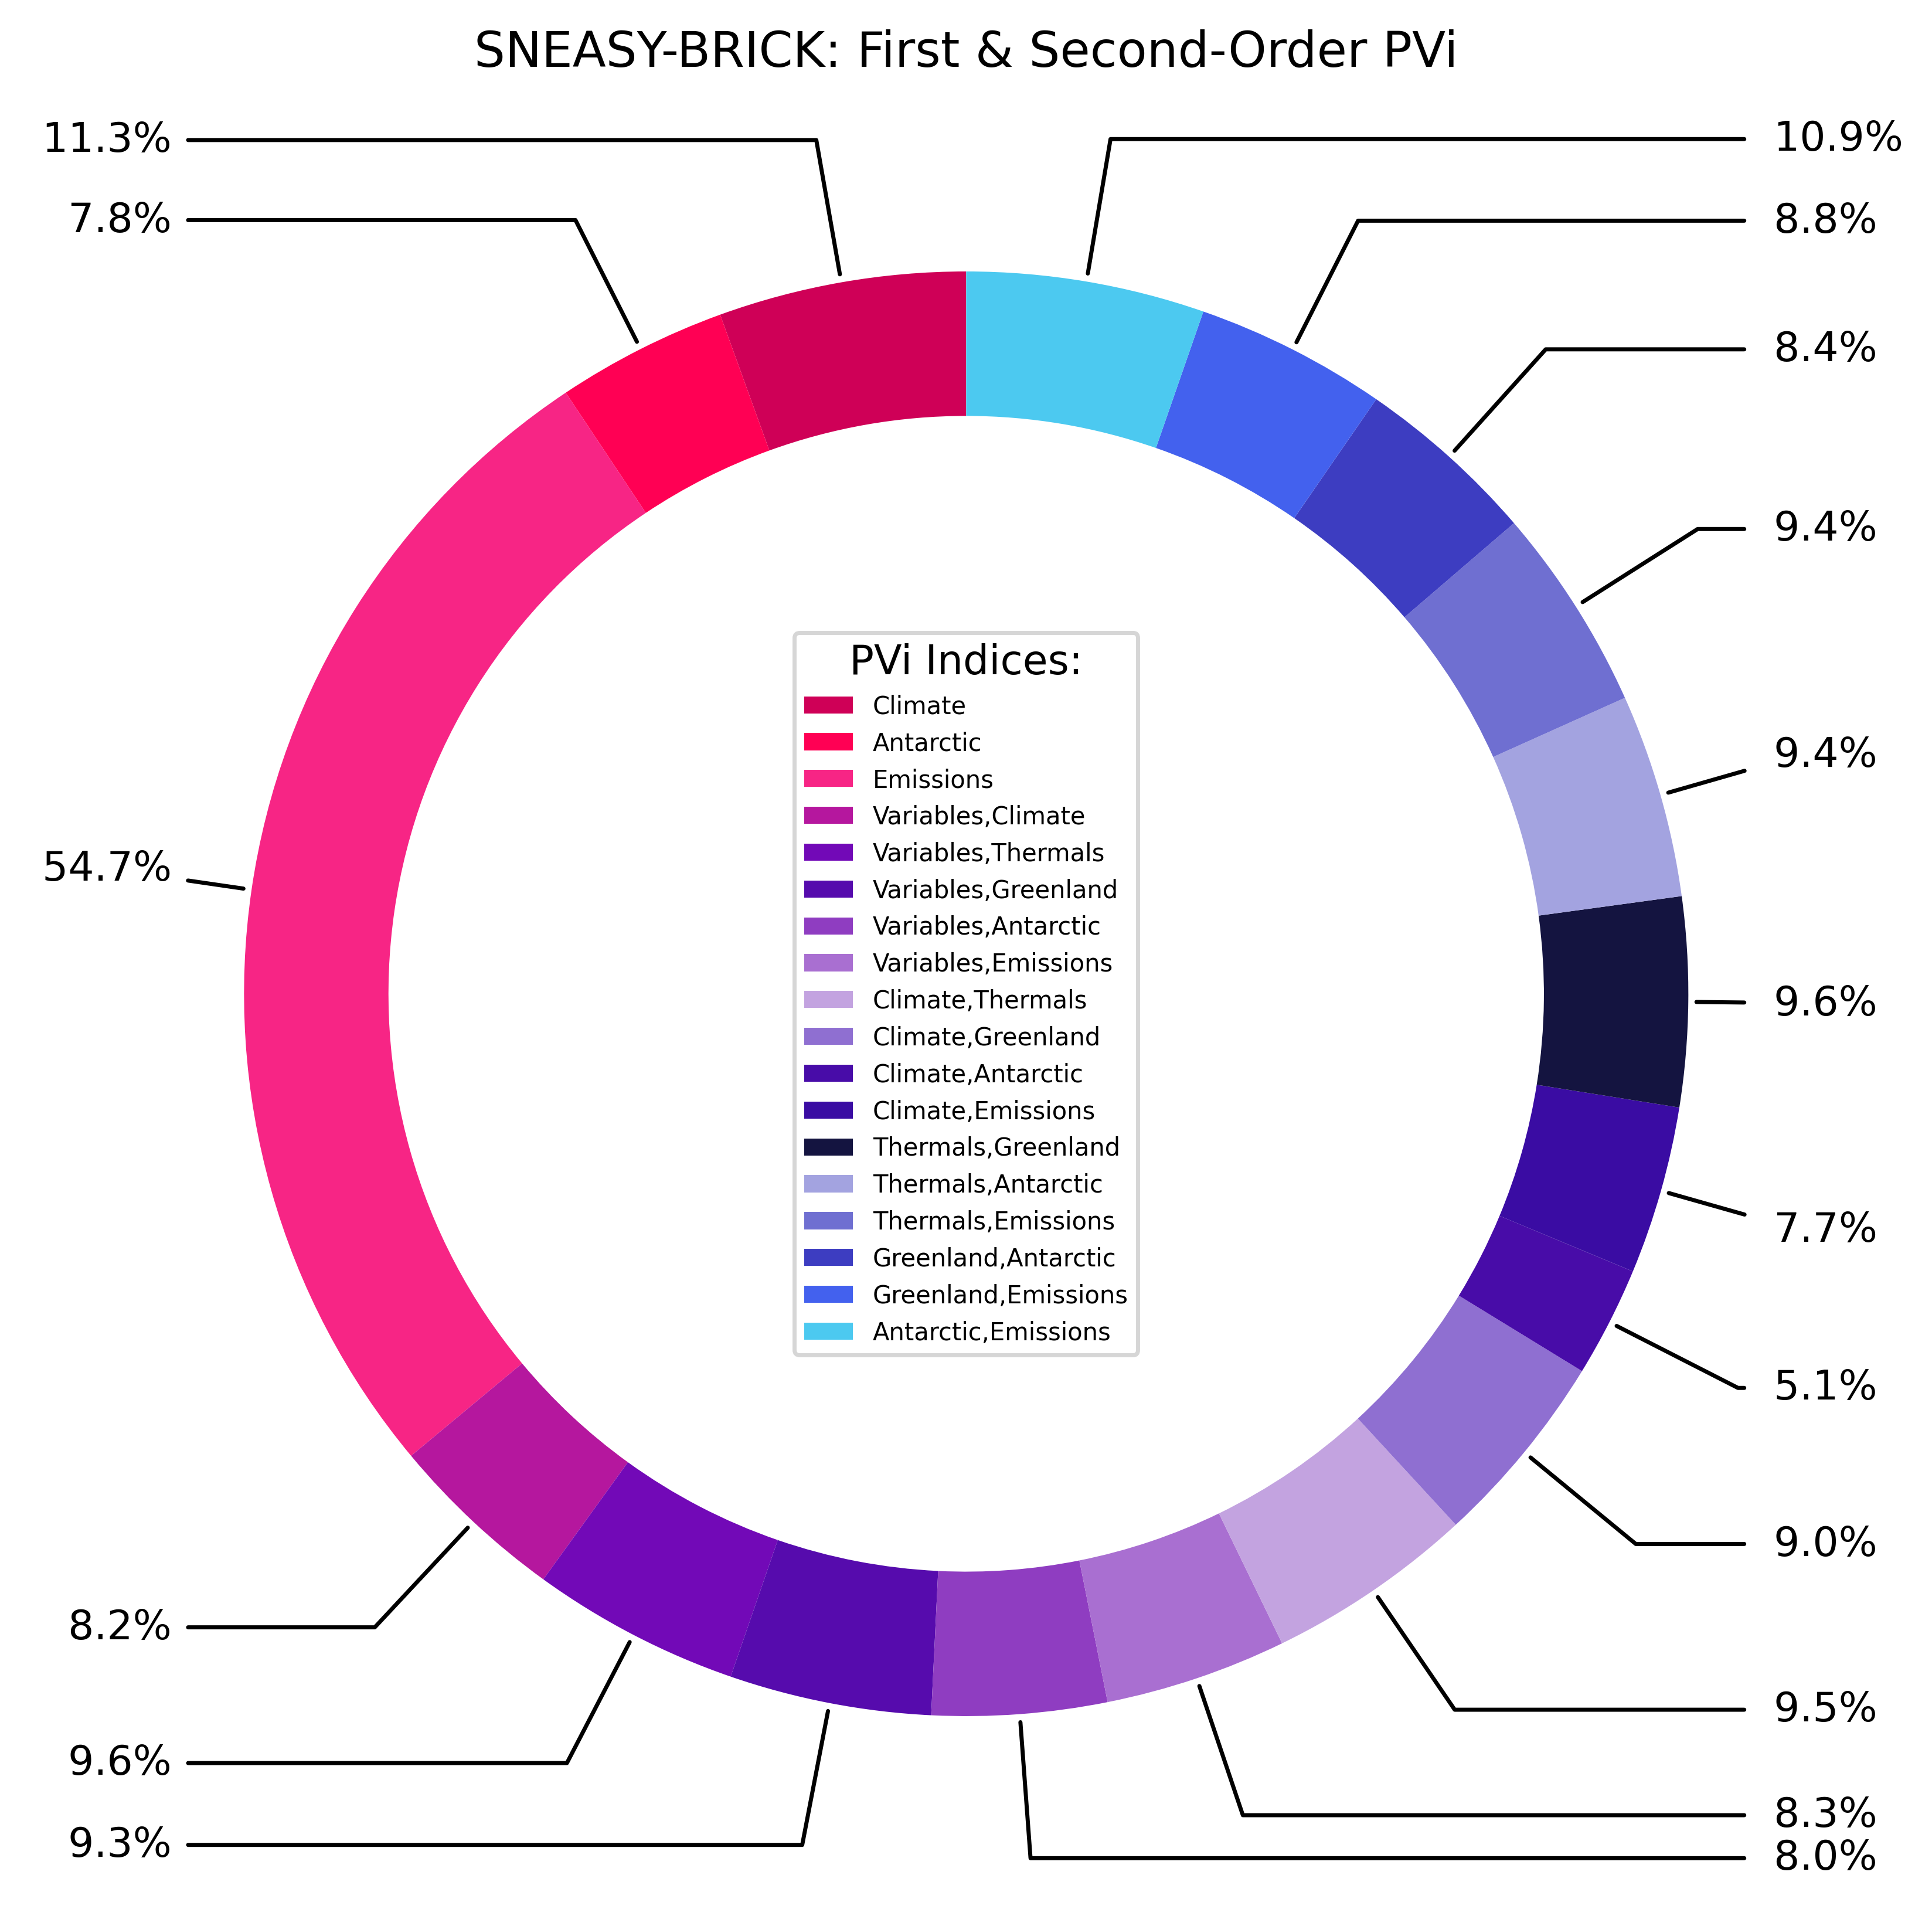

In [44]:
fig, ax= plt.subplots(1,1,dpi=500, figsize=(8,8))
wedges0, text0 = ax.pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
for i, p in enumerate(wedges0):
    ang = (p.theta2-p.theta1)/2 + p.theta1
    x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
    connectionstyle = f'angle, angleA=0, angleB={ang}'
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax.annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
ax.set_title('SNEASY-BRICK: First & Second-Order PVi')
ax.legend(labels=labels,loc='center', title='PVi Indices:' , prop={'size':6})
plt.show()

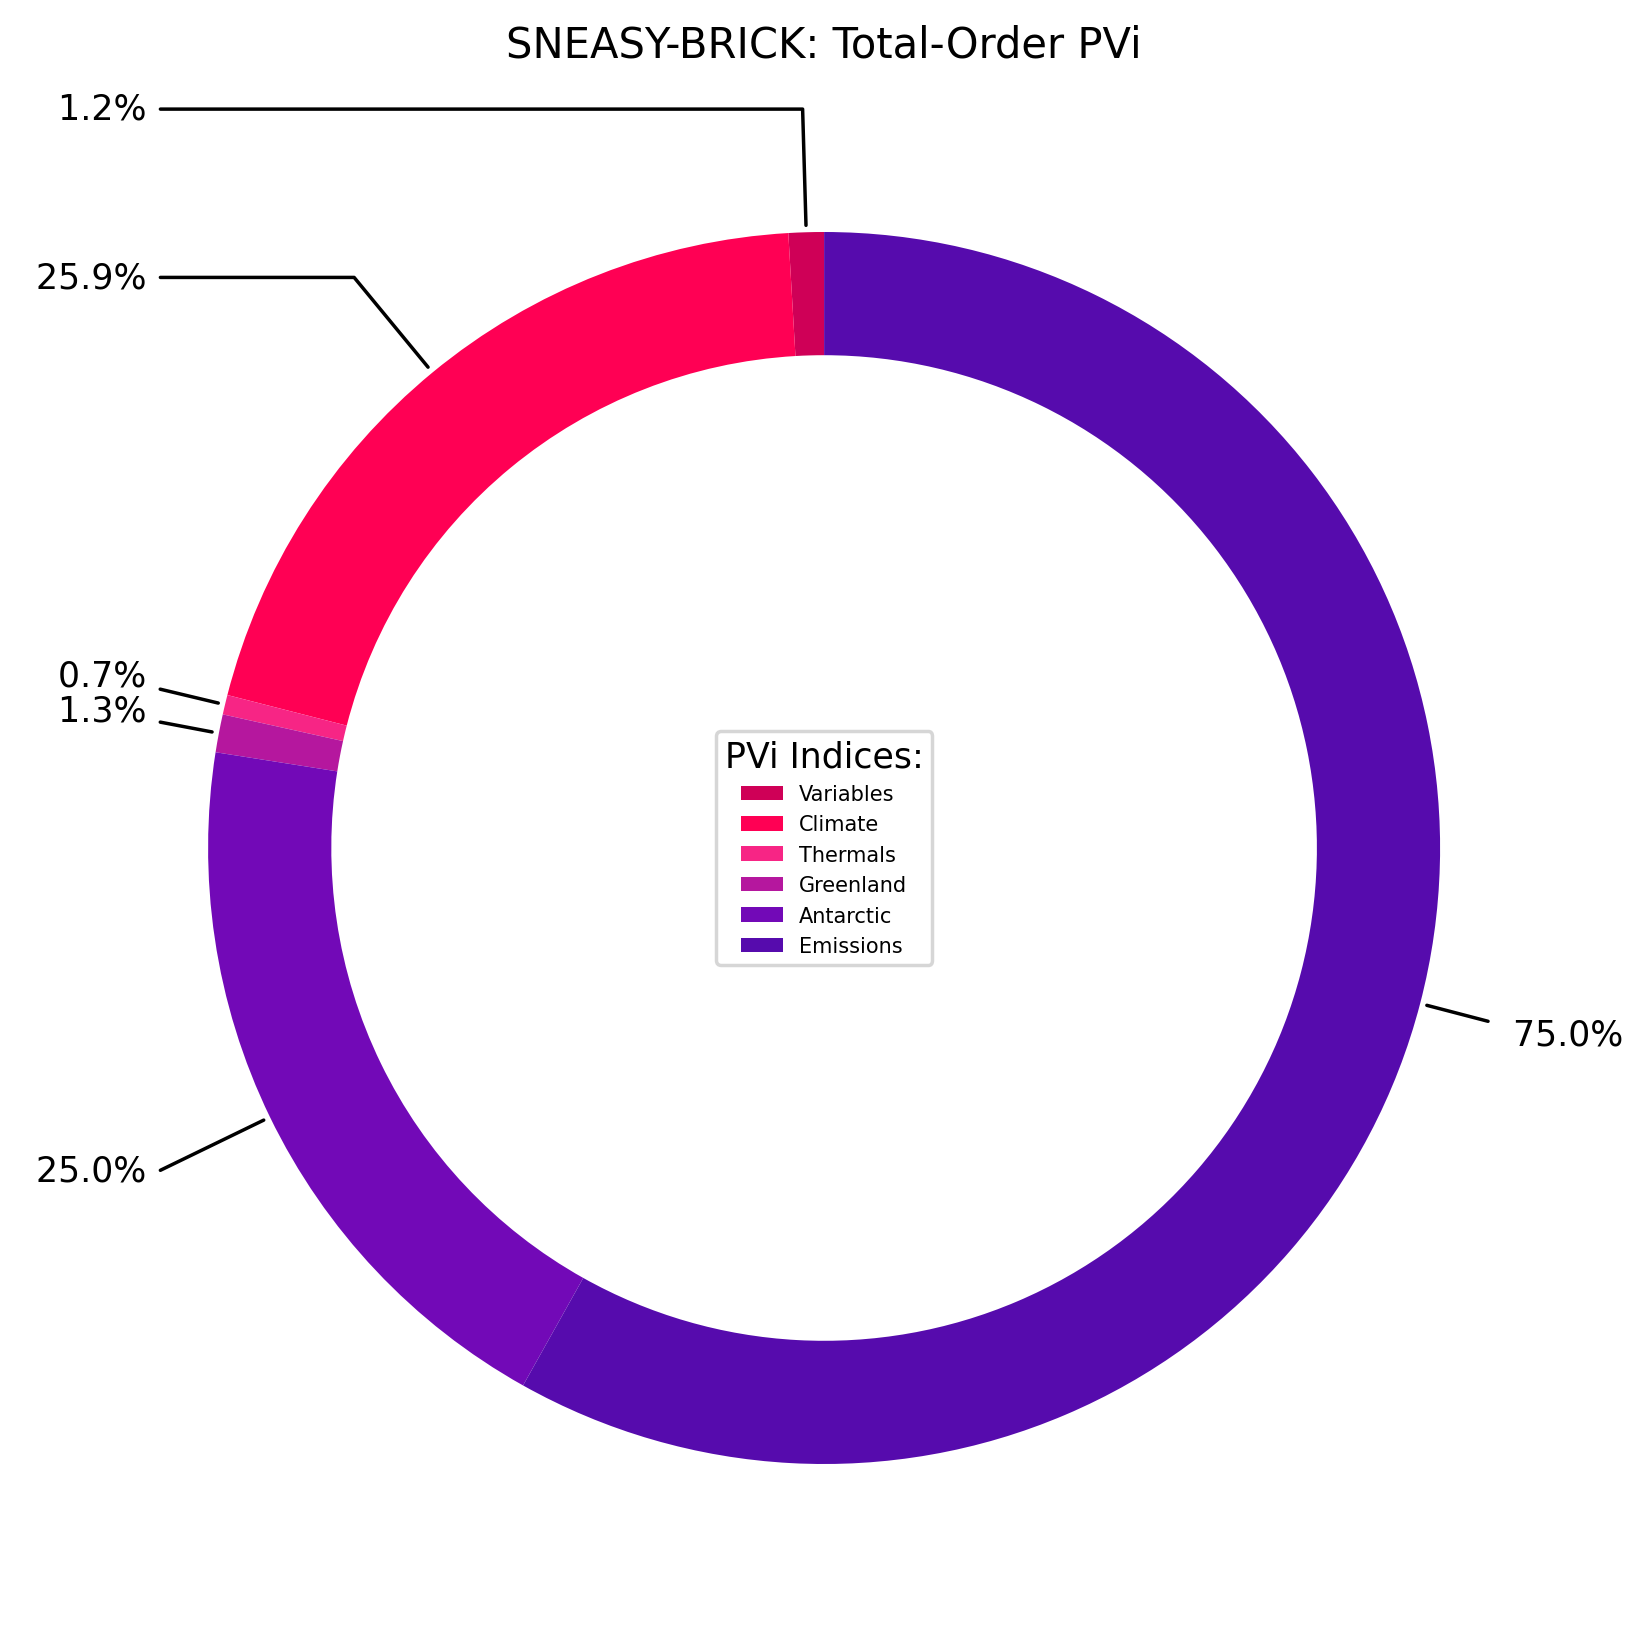

In [45]:
fig, ax= plt.subplots(1,1,dpi=250, figsize=(8,8))
wedges0, text0 = ax.pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
for i, p in enumerate(wedges0):
    ang = (p.theta2-p.theta1)/2 + p.theta1
    x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
    connectionstyle = f'angle, angleA=0, angleB={ang}'
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax.annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
ax.set_title('SNEASY-BRICK: Total-Order PVi')
ax.legend(labels=labels1,loc='center', title='PVi Indices:' , prop={'size':6})
plt.show()

In [46]:
PI_CI = PI.join(CI, how='left')
print(PI_CI.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{i}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & -0.0781 & -0.0864 & -0.0701 & 0.0163 \\
Climate & 0.1135 & 0.1074 & 0.1198 & 0.0124 \\
Thermals & -0.0948 & -0.1027 & -0.0875 & 0.0152 \\
Greenland & -0.0826 & -0.0902 & -0.0749 & 0.0153 \\
Antarctic & 0.0784 & 0.0714 & 0.0861 & 0.0147 \\
Emissions & 0.5474 & 0.5426 & 0.5518 & 0.0092 \\
\bottomrule
\end{tabular}



In [47]:
PT = pd.DataFrame(PT.values(), index=PT.keys(), columns=[r'$P_{\tau}$'])

In [48]:
PT_CT = PT.join(CT, how='left')
print(PT_CT.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{\tau}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & 0.0119 & 0.0117 & 0.0122 & 0.0004 \\
Climate & 0.2591 & 0.2560 & 0.2623 & 0.0063 \\
Thermals & 0.0066 & 0.0065 & 0.0068 & 0.0003 \\
Greenland & 0.0129 & 0.0127 & 0.0131 & 0.0004 \\
Antarctic & 0.2498 & 0.2470 & 0.2524 & 0.0054 \\
Emissions & 0.7500 & 0.7445 & 0.7555 & 0.0110 \\
\bottomrule
\end{tabular}



In [49]:
PIK_CIK = PIK.join(CIK, how='left')
print(PIK_CIK.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{llrrrr}
\toprule
 &  & $P_{ik}$ & 5th & 95th & Quantile Difference \\
\midrule
\multirow[t]{5}{*}{Variables} & Climate & 0.0820 & 0.0757 & 0.0881 & 0.0124 \\
 & Thermals & 0.0957 & 0.0880 & 0.1031 & 0.0152 \\
 & Greenland & 0.0926 & 0.0847 & 0.1007 & 0.0160 \\
 & Antarctic & 0.0802 & 0.0727 & 0.0872 & 0.0145 \\
 & Emissions & 0.0834 & 0.0788 & 0.0878 & 0.0091 \\
\cline{1-6}
\multirow[t]{4}{*}{Climate} & Thermals & 0.0954 & 0.0890 & 0.1015 & 0.0125 \\
 & Greenland & 0.0901 & 0.0836 & 0.0967 & 0.0131 \\
 & Antarctic & 0.0506 & 0.0451 & 0.0560 & 0.0109 \\
 & Emissions & 0.0772 & 0.0740 & 0.0801 & 0.0060 \\
\cline{1-6}
\multirow[t]{3}{*}{Thermals} & Greenland & 0.0959 & 0.0885 & 0.1040 & 0.0155 \\
 & Antarctic & 0.0935 & 0.0866 & 0.1005 & 0.0139 \\
 & Emissions & 0.0938 & 0.0897 & 0.0982 & 0.0085 \\
\cline{1-6}
\multirow[t]{2}{*}{Greenland} & Antarctic & 0.0840 & 0.0766 & 0.0908 & 0.0142 \\
 & Emissions & 0.0879 & 0.0832 & 0.0921 & 0.0089 \\
\cline{1-6}
Antarctic & Emission

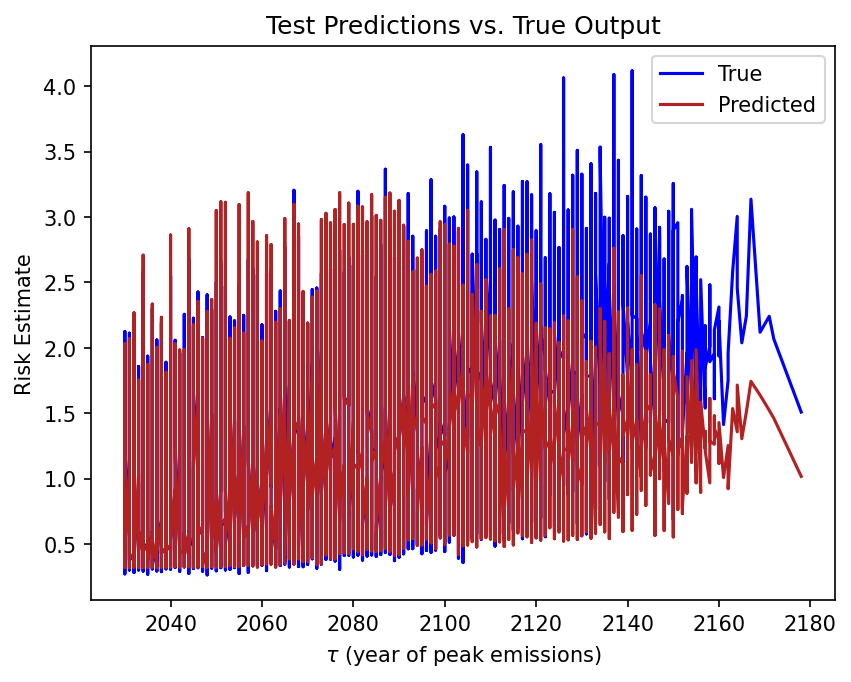

In [59]:


plt.figure(dpi=150)

plt.plot(obj.t_peak, obj.output, color='blue', label='True')
plt.plot(obj.t_peak, RF.predict(obj.iloc[:,:-1]), color='firebrick', label='Predicted')
plt.title('Test Predictions vs. True Output')
plt.ylabel('Risk Estimate')
plt.xlabel(r'$\tau$ (year of peak emissions)')
plt.legend()

## RF Per Year Category

In [20]:
u_years = obj['t_peak'].unique() # Obtain the unique years
mask = u_years<2100

In [15]:
time_PI = dict()
time_PIK = dict()
time_PT = dict()
for year in u_years[mask]:
    # if year>=2161:
    #     pass
    # else:
    #     # print(year)
    mask = obj['t_peak'] < year
    val1 = train_test_split(obj[mask].iloc[:,:-1], obj[mask].iloc[:,-1], train_size=0.5, random_state=0, shuffle=False)
    RF = RandomForestRegressor(n_jobs=10, random_state=0)
    RF.fit(val1[0], val1[2])
    time_PI[year] = mod_pvi1(val1[0], val1[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
    time_PT[year] = mod_pvi_t(val1[0], val1[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
    time_PIK[year] = mod_pvi2(val1[0], val1[2], RF.predict,S_I=time_PI[year], n_boots=1000, alpha=0.05, columns_set=npv_column_set)

In [19]:
res = pd.DataFrame(time_PT.values(), index=time_PT.keys())
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Time_PVI\tot_time_PVI.xlsx")
res = pd.DataFrame(time_PI.values(), index=time_PI.keys())
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Time_PVI\first_time_PVI.xlsx")


# Feature Selection

We will append a noise feature $S_{\mathrm{var}}\sim \mathcal{N}(\mathbf{\overline{0}}, \sigma^{2})$  to the dataset, to accentuate pertinent features. Thereafter, we select features based upon the total-order PVi contribution of $S_{\mathrm{var}}$, as all features contributing $\leqslant$ are equally insignificant.

In [50]:
# Redefing the TPVi for compatibility
def mpt(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = dict()
    V_y = np.var(y_true,ddof=1 )
    CI = dict()
    for col in npv_columns:
        d = data.copy()
        d[col] = np.roll(data[col],rows//2, axis=0)
        y_pred = f(d)
        u[col] = np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u, CI

In [51]:
new_obj = obj1.copy()
S_var = truncnorm.rvs(0, 1,loc=0,scale=1, size=obj1.shape[0], random_state=0)
new_obj.insert(0, 'S_var',S_var)
new_obj.sort_values(by='t_peak',ascending=True, inplace=True)

In [52]:
new_obj.head(5)

,S_var,gamma_g,t_peak,gamma_d,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,...,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
16276,0.488309,0.007032,2030.0,0.144645,0.079195,0.956147,0.000198,0.000258,0.000501,0.001693,...,0.051193,1.091393,1088.769941,87.814430,786.867486,0.000717,0.005617,-16.166066,0.000085,0.315824
41736,0.736103,0.003451,2030.0,0.061238,0.082366,2.101233,0.000321,0.000195,0.000562,0.001214,...,0.069977,1.116511,835.363877,139.616621,764.243450,0.000669,0.008437,-15.812201,0.000060,0.396626
90210,0.155623,0.012165,2030.0,0.069057,0.076762,2.499352,0.000031,0.000265,0.000463,0.000088,...,0.075121,1.785298,1687.506659,119.265613,804.182876,0.000672,0.010296,-15.352471,0.000314,0.379045
9944,0.331022,0.003276,2030.0,0.097613,0.083496,0.728077,0.000243,0.000208,0.000150,0.002657,...,0.080074,1.216362,1351.605944,77.234025,771.381757,0.000650,0.012127,-15.817997,0.000024,0.421145
770,0.245015,0.011439,2030.0,0.061115,0.068154,1.526752,0.000228,0.000248,0.000459,0.002217,...,0.076381,1.368429,1207.103154,76.855079,815.711891,0.000551,0.011492,-15.159269,0.000479,0.621979


In [53]:
# Model Fitting
val1 = train_test_split(new_obj.iloc[:,:-1],new_obj.iloc[:,-1], shuffle=False, train_size=0.8,random_state=0)
# val1 = TimeSeriesSplit(n_splits=4, max_train_size=60_066)
RF1 = RandomForestRegressor(n_estimators=300,n_jobs=20, random_state=0)
RF1.fit(val1[0],val1[2])

RandomForestRegressor(n_estimators=300, n_jobs=20, random_state=0)

In [57]:
def mpv1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for col in npv_columns:
        d = rolled_data.copy()
        d[col] = data[col].to_numpy()
        y_pred = f(d)
        u[col] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u,CI

In [58]:
def mpv2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = dict()
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for col1, col2 in it.combinations(npv_columns, r=2):
        d = rolled_data.copy()
        d[[col1,col2]] = data[[col1,col2]].to_numpy()
        y_pred = f(d)
        S_cat1 = S_I[col1]
        S_cat2 = S_I[col2]
        S[(col1, col2)] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2 # Bootstrap Process
        p0,p1= np.quantile(S_CI, [alpha,1-alpha])
        CI[(col1, col2)] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S, CI

In [64]:
PI, CI = mpv1(val1[0], val1[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val1[0].columns)

In [60]:
PT, CT = mpt(val1[0], val1[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val1[0].columns)

In [61]:
PT = pd.Series(PT.values(), index=PT.keys())
PT

S_var                       0.006304
gamma_g                     0.051060
t_peak                      0.612390
gamma_d                     0.191209
sd_temp                     0.006104
sd_ocean_heat               0.006093
sd_glaciers                 0.006107
sd_greenland                0.006155
sd_antarctic                0.006269
sd_gmsl                     0.006184
rho_temperature             0.006092
rho_ocean_heat              0.006103
rho_glaciers                0.006097
rho_greenland               0.006375
rho_antarctic               0.006110
rho_gmsl                    0.006507
CO2_0                       0.006118
N2O_0                       0.006124
temperature_0               0.006379
ocean_heat_0                0.006328
thermal_s0                  0.006122
greenland_v0                0.006129
glaciers_v0                 0.006132
glaciers_s0                 0.006110
antarctic_s0                0.006088
Q10                         0.008661
CO2_fertilization           0.006147
C

In [66]:
PIK, CIK = mpv2(val1[0], val1[2], RF1.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=val1[0].columns)

In [68]:
PIK = pd.DataFrame(PIK.values(), index=PIK.keys(), columns=[r'$P_{ik}$'])
PIK.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\PVi_model_measures\Second_Order_PVI.xlsx")

In [79]:
# Features <= the importance of S_var
feat_tb_dropped = PT[PT<=PT.loc['S_var']].dropna()

In [80]:
feat_tb_dropped = set(feat_tb_dropped.index) - {'S_var'}

In [82]:
len(list(feat_tb_dropped))

32

Now that I've found the features contributing little to the predicition of the model output, we can remove them and re-train, validate, and test our the new RF model.

**Reloading the dataset**

In [83]:
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
X.drop(columns=list(feat_tb_dropped), inplace=True)
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
obj = X.join(Y, how='left')
obj.sort_values(by='t_peak',ascending=True, inplace=True)
nun = len(X.t_peak.unique())
discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
Y_binned = discret.fit_transform(Y.to_numpy().reshape(-1,1)).ravel()
smote = SMOTENC(categorical_features=['t_peak'],sampling_strategy='auto', random_state=0)
X_res , y_res = smote.fit_resample(X, Y_binned)
Y1 = pd.Series(discret.inverse_transform(y_res.reshape(-1,1)).ravel(), name='output')
new_obj1 = X_res.join(Y1, how='left')
new_obj1.sort_values(by='t_peak',ascending=True, inplace=True)

In [85]:
new_obj1

,gamma_g,t_peak,gamma_d,rho_greenland,rho_gmsl,temperature_0,ocean_heat_0,Q10,CO2_diffusivity,rf_scale_aerosol,...,greenland_a,greenland_b,greenland_alpha,greenland_beta,antarctic_mu,antarctic_precip0,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
83898,0.015287,2030.0,0.009574,0.933043,0.854154,0.017360,-24.172785,1.978648,168.977545,1.073332,...,-2.247887,8.241935,0.000558,0.000073,11.739842,1.222380,0.012035,-14.786948,0.000300,0.962373
42918,0.010062,2030.0,0.177957,0.916469,0.998350,0.036418,-21.674041,1.509308,14.798540,1.122658,...,-2.036855,8.356400,0.000873,0.000012,12.704074,0.317467,0.009558,-15.903148,0.000137,0.430502
25442,0.012275,2030.0,0.136540,0.948663,0.998992,0.006055,-33.465197,1.036937,21.137516,0.893511,...,-1.517964,8.006777,0.000735,0.000055,9.330266,0.873748,0.009117,-15.013547,0.000150,0.315824
37688,0.002872,2030.0,0.041509,0.982859,0.776056,0.008172,-30.081717,2.194133,14.473289,0.907193,...,-2.092960,8.333225,0.000485,0.000061,7.288049,1.137431,0.011675,-15.976176,0.000288,0.396626
93078,0.010923,2030.0,0.063319,0.901913,0.997144,0.058884,-21.992344,2.106068,22.016217,1.157314,...,-3.203819,8.594663,0.000498,0.000016,12.945329,0.468091,0.008591,-15.189987,0.000291,0.473420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52429,0.013229,2167.0,0.093814,0.936862,0.992132,0.038363,-27.160806,1.271833,134.432153,1.166780,...,-1.746194,7.868648,0.000671,0.000055,7.812772,1.144908,0.011739,-16.190533,0.000739,3.286766
26215,0.003130,2169.0,0.022636,0.961795,0.996102,0.041454,-20.081010,1.095023,18.228870,1.244840,...,-1.429014,8.036212,0.000978,0.000023,12.537914,0.378094,0.012827,-16.224729,0.000183,2.139371
87383,0.004158,2171.0,0.120120,0.972183,0.997219,0.070708,-14.455148,1.074390,23.119899,1.494202,...,-2.544064,8.149392,0.000428,0.000079,9.073207,0.226474,0.009879,-15.795974,0.000354,2.230549
43691,0.007347,2172.0,0.049480,0.980064,0.926988,0.046680,-27.969090,1.120413,11.967546,1.153829,...,-0.947703,7.377375,0.000708,0.000251,7.720941,1.168257,0.014322,-15.887230,0.000333,2.072679


**Model Validation/Calibration No.1**\
As this is a time-series dataset, we define a new variable ```val2``` that partitions the dataset (w/o shuffling) into train/validation. When it's time to 'test' the performance of the model, we will switch to ```train_test_split```.

In [86]:
# val2 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
val2 = TimeSeriesSplit(n_splits=4, max_train_size=60_066)
RF = RandomForestRegressor(random_state=0)

**Model Validation/Calibration No.2**\
Defining the parameter space.

In [87]:
parameter_space = dict()
parameter_space['n_estimators'] = Integer(30,400)
# parameter_space['min_samples_split'] = Integer(2,5, prior='uniform')
# parameter_space['min_samples_leaf'] = Integer(1,5)
parameter_space['max_features'] = Integer(5,22)
parameter_space['max_depth'] = Integer(10,80)
# parameter_space['ccp_alpha'] = Real(1e-4, 5e-4)

In [88]:
bae = BayesSearchCV(estimator=RF,search_spaces=parameter_space,verbose=2, n_iter=100, scoring='neg_mean_squared_error', n_points=6, cv=val2, n_jobs=24, random_state=0)
bae.fit(new_obj1.iloc[:,:-1], new_obj1.iloc[:,-1])
res = pd.DataFrame(bae.cv_results_)
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_FS_3.xlsx")
res.to_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_FS_3.csv")
print(f'Best Parameters:{bae.best_params_} with MSE: {bae.best_score_}')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Parameters:OrderedDict([('max_depth

In [89]:
val2 = train_test_split(new_obj1.iloc[:,:-1],new_obj1.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
RF1 = RandomForestRegressor(n_estimators=400, max_features=18, max_depth=76, n_jobs=20, random_state=0)
RF1.fit(val2[0], val2[2])

RandomForestRegressor(max_depth=76, max_features=18, n_estimators=400,
                      n_jobs=20, random_state=0)

In [92]:
val2[0].columns

Index(['gamma_g', 't_peak', 'gamma_d', 'rho_greenland', 'rho_gmsl',
       'temperature_0', 'ocean_heat_0', 'Q10', 'CO2_diffusivity',
       'rf_scale_aerosol', 'climate_sensitivity', 'thermal_alpha',
       'greenland_a', 'greenland_b', 'greenland_alpha', 'greenland_beta',
       'antarctic_mu', 'antarctic_precip0', 'antarctic_lambda',
       'antarctic_temp_threshold', 'lw_random_sample'],
      dtype='object')

In [102]:
Variables = ['sd_temp', 'sd_ocean_heat', 'sd_glaciers', 'sd_greenland','sd_antarctic',
              'sd_gmsl', 'rho_temperature','rho_ocean_heat', 
              'rho_glaciers', 'rho_greenland', 'rho_antarctic','rho_gmsl']
Climate = ['CO2_0', 'N2O_0', 'temperature_0','ocean_heat_0','Q10', 'CO2_fertilization',
           'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol','climate_sensitivity']
Glaciers = ['glaciers_v0','glaciers_s0','glaciers_beta0', 'glaciers_n']
Thermals = ['thermal_s0', 'thermal_alpha']

Greenland = ['greenland_a', 'greenland_b','greenland_alpha', 'greenland_beta']
Antarctic = [ 'antarctic_gamma', 'antarctic_alpha','antarctic_mu', 'antarctic_nu',
              'antarctic_precip0', 'antarctic_kappa','antarctic_flow0', 'antarctic_runoff_height0',
                'antarctic_c','antarctic_bed_height0', 'antarctic_slope', 'antarctic_lambda','antarctic_temp_threshold',
                'antarctic_s0','anto_alpha', 'anto_beta']
variables = list(set(Variables) & set(val2[0].columns))
climate = list(set(Climate) & set(val2[0].columns))
thermals = list(set(Thermals) & set(val2[0].columns))
greenland = list(set(Greenland) & set(val2[0].columns))
antarctic = list(set(Antarctic) & set(val2[0].columns))
npv_column_set = dict()
npv_column_set['Variables'] = variables
npv_column_set['Climate'] = climate
# npv_column_set['Glaciers'] = Glaciers
npv_column_set['Thermals'] = thermals
npv_column_set['Greenland'] = greenland
npv_column_set['Antarctic'] = antarctic
npv_column_set['Emissions'] = ['gamma_g', 't_peak', 'gamma_d', 'lw_random_sample']

In [90]:
print(f'Train MSE={np.mean(np.square(val2[2].to_numpy()-RF1.predict(val2[0].to_numpy())))}')
print(f'Test MSE={np.mean(np.square(val2[3].to_numpy()-RF1.predict(val2[1].to_numpy())))}')

C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Train MSE=0.0020839918192476813
Test MSE=0.13663695819821262


C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


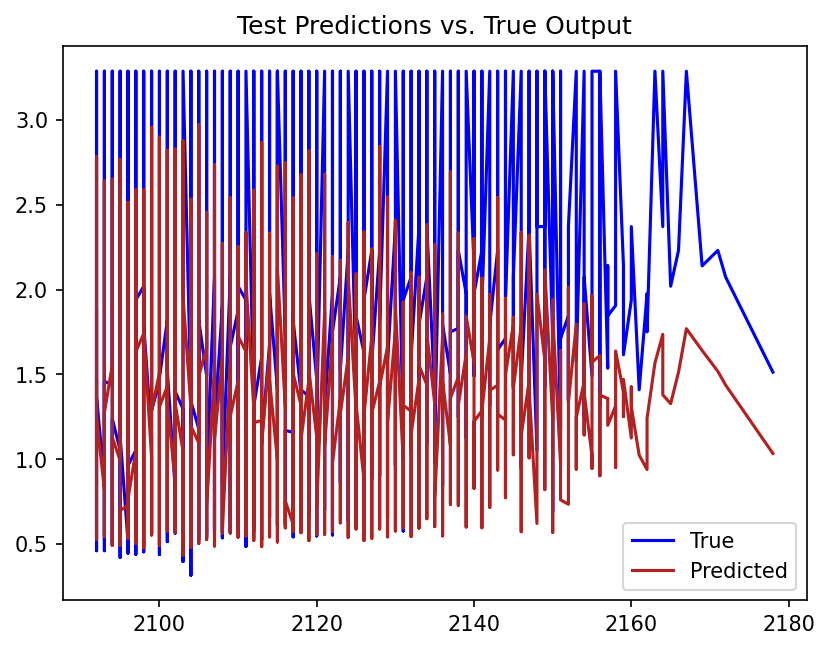

In [91]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)

plt.plot(val2[1].t_peak, val2[3], color='blue', label='True')
plt.plot(val2[1].t_peak, RF1.predict(val2[1]), color='firebrick', label='Predicted')
plt.title('Test Predictions vs. True Output')
plt.legend()

In [103]:
PI, CI = mod_pvi1(val2[0], val2[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
PIK, CIK = mod_pvi2(val2[0], val2[2], RF1.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=npv_column_set)

In [ ]:
PI = pd.DataFrame(PI.values(), index=PI.keys(), columns=[r'$P_{i}$'])
PIK = pd.DataFrame(PIK.values(), index=PIK.keys(), columns=[r'$P_{ik}$'])

In [109]:
PI_confide = PI.join(CI, how='left')
PIK_confide = PIK.join(CIK, how='left')

In [110]:
print(PI_confide.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{i}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & -0.0854 & -0.0932 & -0.0773 & 0.0159 \\
Climate & -0.0683 & -0.0758 & -0.0606 & 0.0152 \\
Thermals & -0.0905 & -0.0985 & -0.0820 & 0.0165 \\
Greenland & -0.0802 & -0.0886 & -0.0723 & 0.0163 \\
Antarctic & -0.0481 & -0.0553 & -0.0410 & 0.0143 \\
Emissions & 0.1069 & 0.0997 & 0.1139 & 0.0142 \\
\bottomrule
\end{tabular}



In [111]:
print(PIK_confide.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{llrrrr}
\toprule
 &  & $P_{ik}$ & 5th & 95th & Quantile Difference \\
\midrule
\multirow[t]{5}{*}{Variables} & Climate & 0.0867 & 0.0789 & 0.0939 & 0.0150 \\
 & Thermals & 0.0930 & 0.0855 & 0.1011 & 0.0156 \\
 & Greenland & 0.0908 & 0.0835 & 0.0986 & 0.0151 \\
 & Antarctic & 0.0859 & 0.0786 & 0.0933 & 0.0147 \\
 & Emissions & 0.0871 & 0.0799 & 0.0940 & 0.0141 \\
\cline{1-6}
\multirow[t]{4}{*}{Climate} & Thermals & 0.0923 & 0.0840 & 0.0997 & 0.0157 \\
 & Greenland & 0.0834 & 0.0756 & 0.0904 & 0.0148 \\
 & Antarctic & 0.0406 & 0.0332 & 0.0479 & 0.0147 \\
 & Emissions & 0.0876 & 0.0799 & 0.0943 & 0.0144 \\
\cline{1-6}
\multirow[t]{3}{*}{Thermals} & Greenland & 0.0923 & 0.0842 & 0.1000 & 0.0158 \\
 & Antarctic & 0.0898 & 0.0822 & 0.0975 & 0.0153 \\
 & Emissions & 0.0901 & 0.0829 & 0.0971 & 0.0142 \\
\cline{1-6}
\multirow[t]{2}{*}{Greenland} & Antarctic & 0.0778 & 0.0701 & 0.0848 & 0.0146 \\
 & Emissions & 0.0839 & 0.0770 & 0.0911 & 0.0142 \\
\cline{1-6}
Antarctic & Emission

In [119]:
# PI[PI>0].dropna()['$P_{i}$'].to_dict()
pik = PIK.to_dict()['$P_{ik}$']
ref_pik = {','.join(key): pik[key] for key in pik.keys()}
merged_measures =  PI[PI>0].dropna()['$P_{i}$'].to_dict()|ref_pik

In [120]:
values = list(merged_measures.values())
labels = list(merged_measures.keys())

In [121]:
PT, CT = mod_pvi_t(val2[0], val2[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)

In [124]:
values2 = list(PT.values())
labels2 = list(PT.keys())

In [139]:
def donut_chart(values: np.ndarray, values1: np.ndarray, labels: list,labels1: list, props: dict, kw: dict):
    fig, ax= plt.subplots(1,2, dpi=400, figsize=(20,25))
    wedges0, text0 = ax[0].pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges0):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[0].annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[0].set_title('SNEASY-BRICK: First & Second-Order PVi')
    ax[0].legend(labels=labels,loc='center', title='PVi Indices:' )

    wedges1, text1 = ax[1].pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges1):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[1].annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[1].set_title('SNEASY-BRICK: Total-Order PVi')
    ax[1].legend(labels=labels1,loc='center', title='PVi Indices:' )
    plt.show()

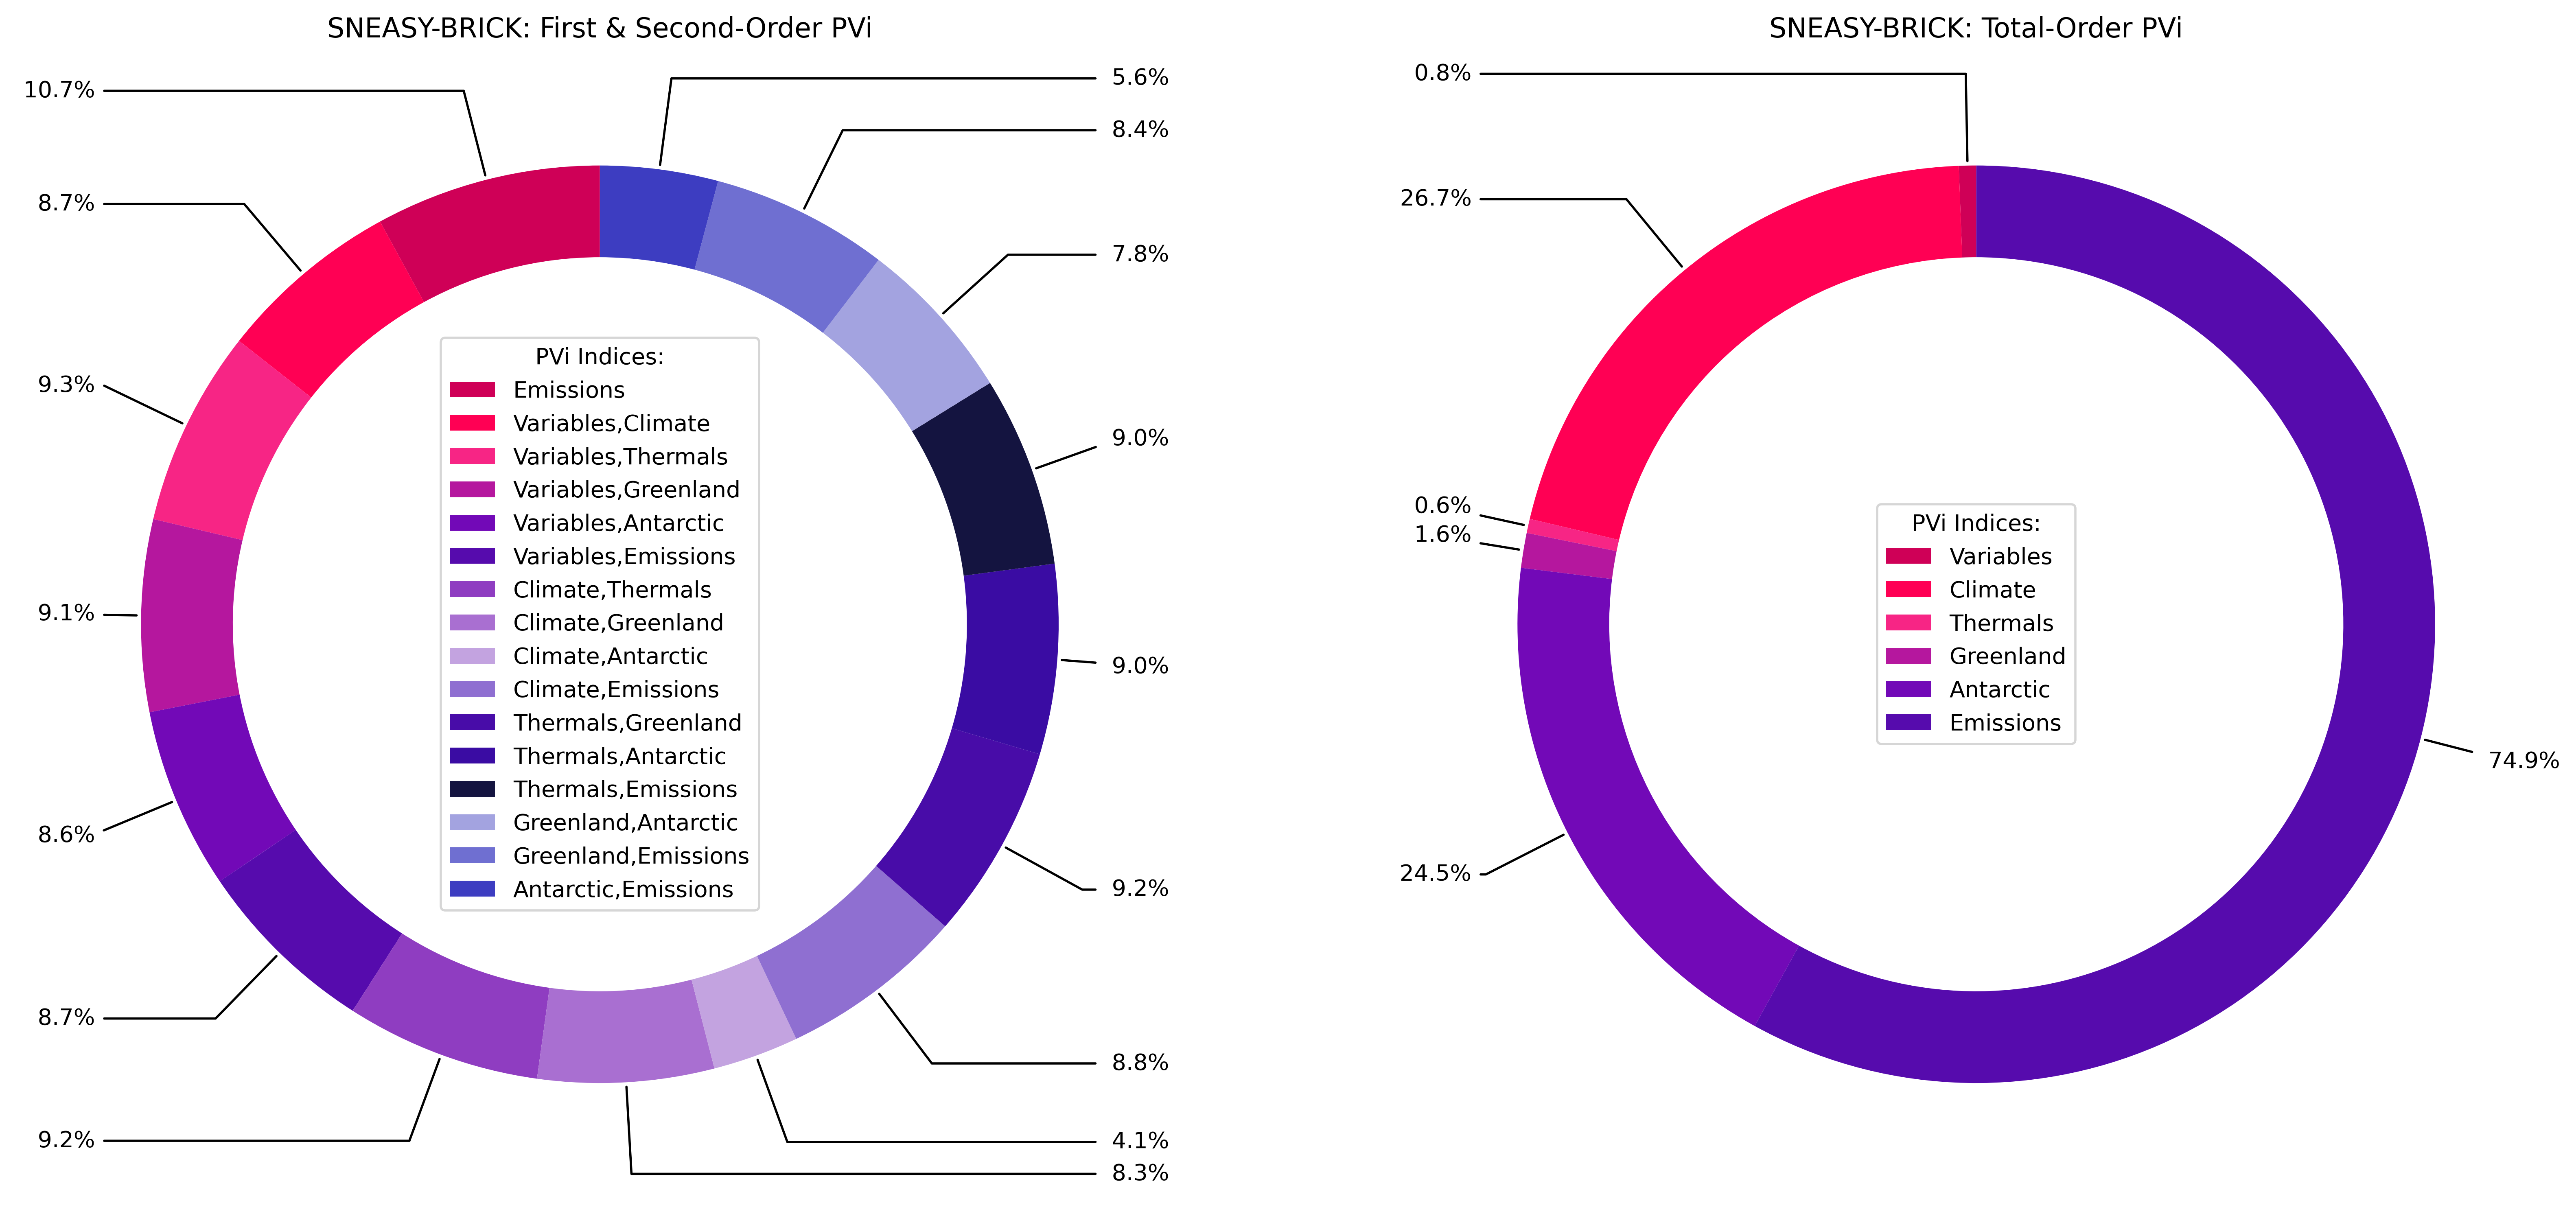

In [140]:
donut_chart(values, values2, labels, labels2, props, kw)